In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [52]:
# Гиперпараметры
batch_size = 128
learning_rate = 0.001
num_epochs = 5

In [53]:
# Загрузка и преобразование данных
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


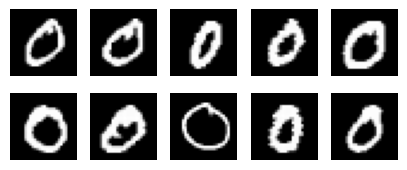

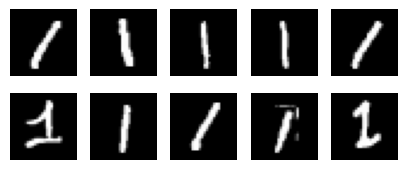

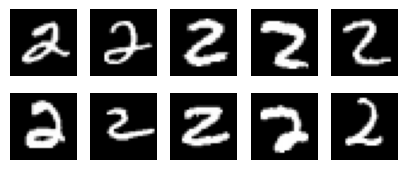

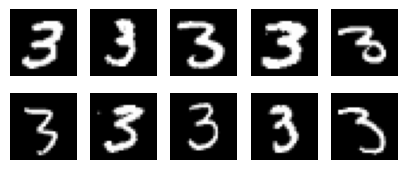

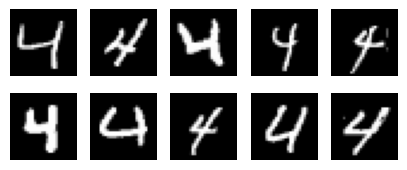

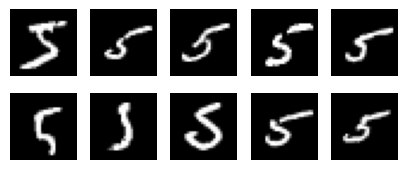

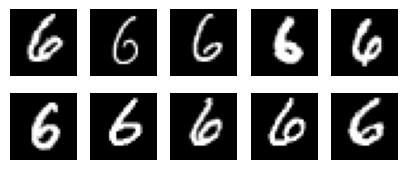

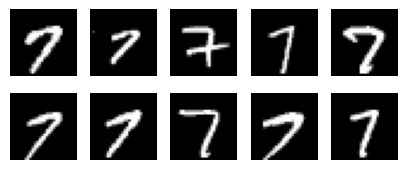

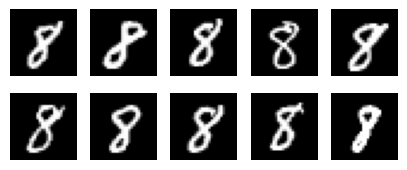

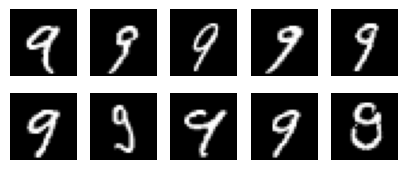

In [20]:
# plot all examples for each lables 
for i in range(10):
    plt.figure(figsize=(5, 2))
    for j in range(10):
        plt.subplot(2, 5, j + 1)
        plt.imshow(train_dataset.data[train_dataset.targets == i][j], cmap='gray')
        plt.axis('off')
    plt.show()

In [22]:
# Определение модели
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Развернуть изображение в вектор
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [54]:
# Инициализация модели, функции потерь и оптимизатора
model = FCN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print(f'Using device: {device}')

Using device: mps


In [57]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/5], Loss: 0.2327
Epoch [2/5], Loss: 0.2059
Epoch [3/5], Loss: 0.1030
Epoch [4/5], Loss: 0.1856
Epoch [5/5], Loss: 0.0760


In [58]:
# Оценка модели и расчет метрик
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

# Метрики классификации
print("Classification Report:")
print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.94      0.98      0.96      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.95      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.95      0.98      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy: 0.9731


In [62]:
# Визуализация ошибок классификации
def plot_errors(model, num_images=10):
    model.eval()
    errors_shown = 0
    
    plt.figure(figsize=(15, 3))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            print(preds, labels)
            # Находим индексы ошибочных предсказаний
            errors = (preds != labels).nonzero().squeeze()
            
            for idx in errors:
                if errors_shown >= num_images:
                    break
                plt.subplot(1, num_images, errors_shown + 1)
                plt.imshow(images[idx].detach().cpu().view(28, 28), cmap="gray")
                plt.title(f'Pred: {preds[idx].item()}\nTrue: {labels[idx].item()}')
                plt.axis('off')
                errors_shown += 1

            if errors_shown >= num_images:
                break
    
    if errors_shown == 0:
        plt.title("No errors found!")
    
# Показываем первые 10 ошибок классификации
plot_errors(model)
plt.show()


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 2, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5], device='mps:0') tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5], device='mps:0')


TypeError: iteration over a 0-d tensor

<Figure size 1500x300 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch

# Функция для обработки изображения
def process_image(image_path):
    # Открываем изображение и переводим в черно-белый формат
    image = Image.open(image_path).convert('L')
    # Изменяем размер до 28x28
    image = image.resize((28, 28))
    # Преобразуем изображение в тензор и нормализуем его
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = transform(image)
    # swap black and white
    image = image.max() - image
    # Добавляем измерение батча
    image = image.unsqueeze(0)
    return image

# Функция для предсказания числа на изображении
def predict_image(image_path, model, device):
    # Обрабатываем изображение и перемещаем на устройство
    image = process_image(image_path).to(device)
    # Прогоняем через модель
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item(), image.squeeze(0).cpu()  # Возвращаем также оригинальное изображение для отображения

# Функция для отображения изображения с предсказанием
def show_prediction(image_path, model, device):
    # Получаем предсказание и изображение
    prediction, image = predict_image(image_path, model, device)
    # Отображаем изображение с предсказанным числом
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title(f'Pred: {prediction}')
    plt.axis('off')
    plt.show()

# Пример использования
image_path = '1.png'  # Замените на путь к вашему изображению
show_prediction(image_path, model, device)


FileNotFoundError: [Errno 2] No such file or directory: '1.png'